In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Dropout, Concatenate, Bidirectional, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

In [2]:
# Load your processed dataset with text and labels
data = pd.read_csv('processed_with_labels_7allV03.csv')
texts = data['processed_text'].values
labels = data['label'].values

# Tokenization for random embeddings
max_words = 10000  # Maximum number of words to keep
max_len = 100      # Maximum length of each text

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X_random = pad_sequences(sequences, maxlen=max_len)

# Split the data
X_random_train, X_random_test, y_train, y_test = train_test_split(
    X_random, labels, test_size=0.2, random_state=42
)

In [3]:
# Load your Word2Vec features
word2vec_features = pd.read_csv('word2vec_features_3.csv')
X_w2v = word2vec_features.values

# Split Word2Vec data
X_w2v_train, X_w2v_test, y_train_w2v, y_test_w2v = train_test_split(
    X_w2v, labels, test_size=0.2, random_state=42
)

# Reshape for CNN input
X_w2v_train_reshaped = X_w2v_train.reshape(X_w2v_train.shape[0], X_w2v_train.shape[1], 1)
X_w2v_test_reshaped = X_w2v_test.reshape(X_w2v_test.shape[0], X_w2v_test.shape[1], 1)

In [4]:
def create_ensemble_model_random(max_words, max_len, embedding_dim=100, num_classes=len(np.unique(labels))):
    # Input layer
    input_layer = Input(shape=(max_len,))
    
    # Embedding layer
    embedding = Embedding(max_words, embedding_dim, input_length=max_len)(input_layer)
    
    # CNN branch
    conv1 = Conv1D(128, 5, activation='relu')(embedding)
    pool1 = GlobalMaxPooling1D()(conv1)
    
    # LSTM branch
    lstm = LSTM(64, return_sequences=True)(embedding)
    lstm = GlobalMaxPooling1D()(lstm)
    
    # BiLSTM branch
    bilstm = Bidirectional(LSTM(64, return_sequences=True))(embedding)
    bilstm = GlobalMaxPooling1D()(bilstm)
    
    # GRU branch
    gru = GRU(64, return_sequences=True)(embedding)
    gru = GlobalMaxPooling1D()(gru)
    
    # Concatenate all branches
    concat = Concatenate()([pool1, lstm, bilstm, gru])
    
    # Dense layers
    dense1 = Dense(256, activation='relu')(concat)
    dropout1 = Dropout(0.5)(dense1)
    dense2 = Dense(128, activation='relu')(dropout1)
    dropout2 = Dropout(0.5)(dense2)
    
    # Output layer
    output = Dense(num_classes, activation='softmax')(dropout2)
    
    # Create model
    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss='sparse_categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    
    return model

In [5]:
def create_ensemble_model_w2v(input_shape, num_classes=len(np.unique(labels))):
    # Input layer
    input_layer = Input(shape=input_shape)
    
    # CNN branch
    conv1 = Conv1D(128, 5, activation='relu')(input_layer)
    pool1 = GlobalMaxPooling1D()(conv1)
    
    # LSTM branch
    lstm = LSTM(64, return_sequences=True)(input_layer)
    lstm = GlobalMaxPooling1D()(lstm)
    
    # BiLSTM branch
    bilstm = Bidirectional(LSTM(64, return_sequences=True))(input_layer)
    bilstm = GlobalMaxPooling1D()(bilstm)
    
    # GRU branch
    gru = GRU(64, return_sequences=True)(input_layer)
    gru = GlobalMaxPooling1D()(gru)
    
    # Concatenate all branches
    concat = Concatenate()([pool1, lstm, bilstm, gru])
    
    # Dense layers
    dense1 = Dense(256, activation='relu')(concat)
    dropout1 = Dropout(0.5)(dense1)
    dense2 = Dense(128, activation='relu')(dropout1)
    dropout2 = Dropout(0.5)(dense2)
    
    # Output layer
    output = Dense(num_classes, activation='softmax')(dropout2)
    
    # Create model
    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss='sparse_categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    
    return model

In [6]:
def evaluate_model_detailed(y_true, y_pred, y_pred_proba, model_name):
    """
    Comprehensive model evaluation function
    """
    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # ROC Curve and AUC for each class
    n_classes = len(np.unique(y_true))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {model_name}')
    plt.legend()
    plt.show()
    
    # Calculate mean AUC
    mean_auc = np.mean(list(roc_auc.values()))
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': mean_auc,
        'confusion_matrix': cm,
        'roc_auc_per_class': roc_auc
    }

In [7]:
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=250,
        batch_size=16,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Get predictions
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Detailed evaluation
    evaluation_results = evaluate_model_detailed(y_test, y_pred, y_pred_proba, model_name)
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    return history, evaluation_results

In [8]:
def generate_comparison_report(random_results, w2v_results):
    """
    Generate a detailed comparison report of both models
    """
    # Create comparison DataFrame
    comparison_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Mean AUC'],
        'Random Embeddings': [
            random_results['accuracy'],
            random_results['precision'],
            random_results['recall'],
            random_results['f1'],
            random_results['auc']
        ],
        'Word2Vec': [
            w2v_results['accuracy'],
            w2v_results['precision'],
            w2v_results['recall'],
            w2v_results['f1'],
            w2v_results['auc']
        ]
    })
    
    # Format numbers
    comparison_df.iloc[:, 1:] = comparison_df.iloc[:, 1:].round(4)
    
    # Generate report text
    report = "Model Comparison Report\n"
    report += "=====================\n\n"
    report += "Performance Metrics Comparison:\n"
    report += str(comparison_df) + "\n\n"
    
    # Determine best model for each metric
    metrics = ['Accuracy', 'Precision', 'Recall']
    for metric in metrics:
        random_value = comparison_df.loc[comparison_df['Metric'] == metric, 'Random Embeddings'].values[0]
        w2v_value = comparison_df.loc[comparison_df['Metric'] == metric, 'Word2Vec'].values[0]
        
        best_model = 'Random Embeddings' if random_value > w2v_value else 'Word2Vec'
        report += f"Best {metric}: {best_model} ({max(random_value, w2v_value):.4f})\n"
    
    # Overall recommendation
    random_avg = comparison_df.iloc[:3, 1].mean()  # Average of accuracy, precision, recall
    w2v_avg = comparison_df.iloc[:3, 2].mean()
    best_overall = 'Random Embeddings' if random_avg > w2v_avg else 'Word2Vec'
    
    report += f"\nOverall Best Model: {best_overall}\n"
    report += f"Based on average of accuracy, precision, and recall scores.\n"
    
    return report



Training model with random embeddings...


c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/250
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.1604 - loss: 1.9470 - val_accuracy: 0.3355 - val_loss: 1.7972
Epoch 2/250
196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.3500 - loss: 1.6103 - val_accuracy: 0.6786 - val_loss: 0.9362
Epoch 3/250
196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.7549 - loss: 0.6856 - val_accuracy: 0.7997 - val_loss: 0.6792
Epoch 4/250
196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9444 - loss: 0.2062 - val_accuracy: 0.8278 - val_loss: 0.6743
Epoch 5/250
196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9723 - loss: 0.1084 - val_accuracy: 0.8304 - val_loss: 0.7472
Epoch 6/250
196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9909 - loss: 0.0461 - val_accuracy: 0.8189 - val_loss: 1.0161
Epoch 7/250
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.9929 - loss: 0.0289 - val_accuracy: 0.8240 - val_loss: 1.0618
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


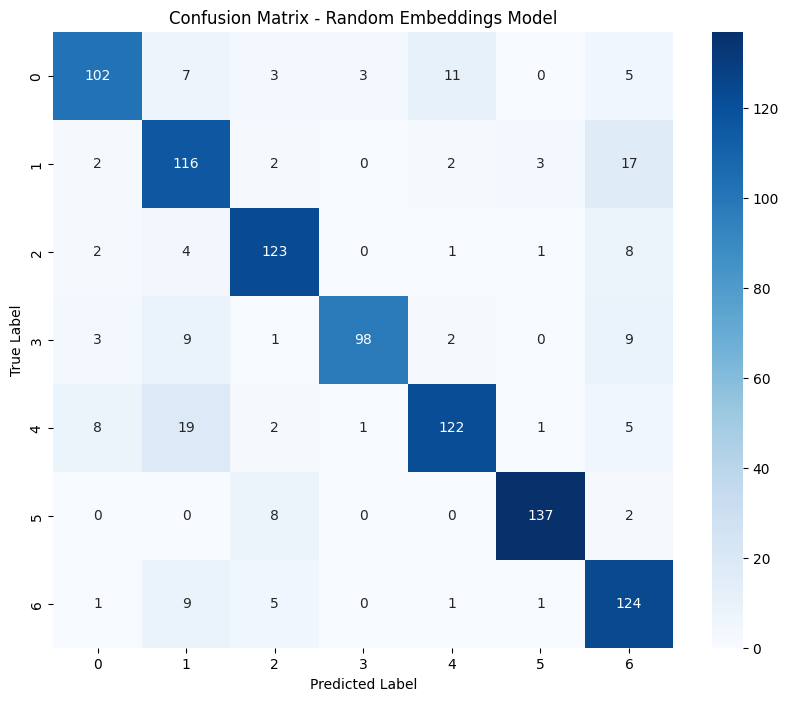

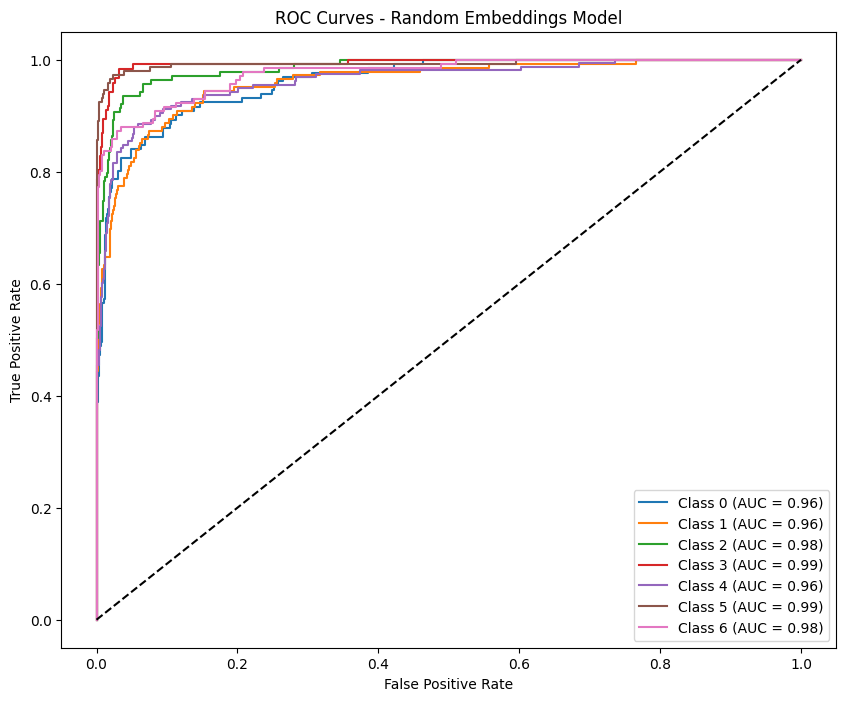

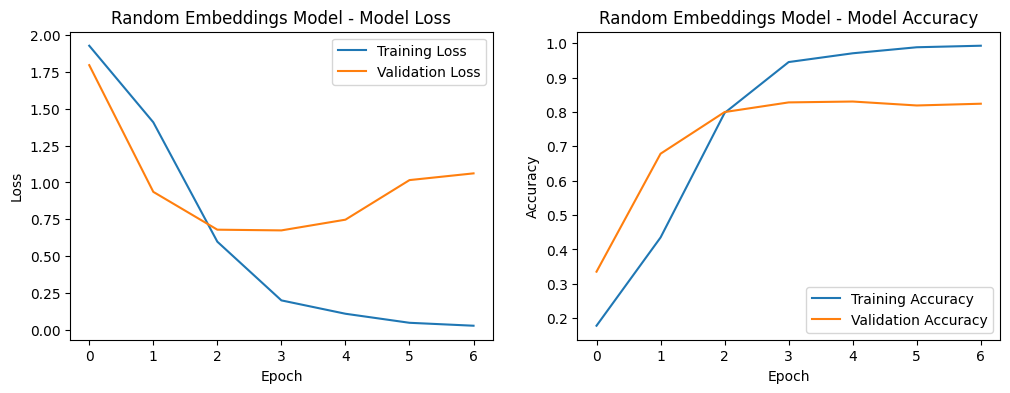


Training model with Word2Vec embeddings...
Epoch 1/250
196/196 ━━━━━━━━━━━━━━━━━━━━ 34s 151ms/step - accuracy: 0.1502 - loss: 1.9477 - val_accuracy: 0.1901 - val_loss: 1.9397
Epoch 2/250
196/196 ━━━━━━━━━━━━━━━━━━━━ 31s 157ms/step - accuracy: 0.1506 - loss: 1.9446 - val_accuracy: 0.2934 - val_loss: 1.9207
Epoch 3/250
196/196 ━━━━━━━━━━━━━━━━━━━━ 31s 156ms/step - accuracy: 0.2003 - loss: 1.9083 - val_accuracy: 0.3444 - val_loss: 1.7479
Epoch 4/250
196/196 ━━━━━━━━━━━━━━━━━━━━ 31s 160ms/step - accuracy: 0.3020 - loss: 1.7502 - val_accuracy: 0.3992 - val_loss: 1.5810
Epoch 5/250
196/196 ━━━━━━━━━━━━━━━━━━━━ 30s 156ms/step - accuracy: 0.3770 - loss: 1.5989 - val_accuracy: 0.4158 - val_loss: 1.5264
Epoch 6/250
196/196 ━━━━━━━━━━━━━━━━━━━━ 30s 151ms/step - accuracy: 0.4434 - loss: 1.5358 - val_accuracy: 0.4898 - val_loss: 1.3603
Epoch 7/250
196/196 ━━━━━━━━━━━━━━━━━━━━ 30s 153ms/step - accuracy: 0.4831 - loss: 1.3928 - val_accuracy: 0.5140 - val_loss: 1.2889
Epoch 8/250
196/196 ━━━━━━━━━━━━

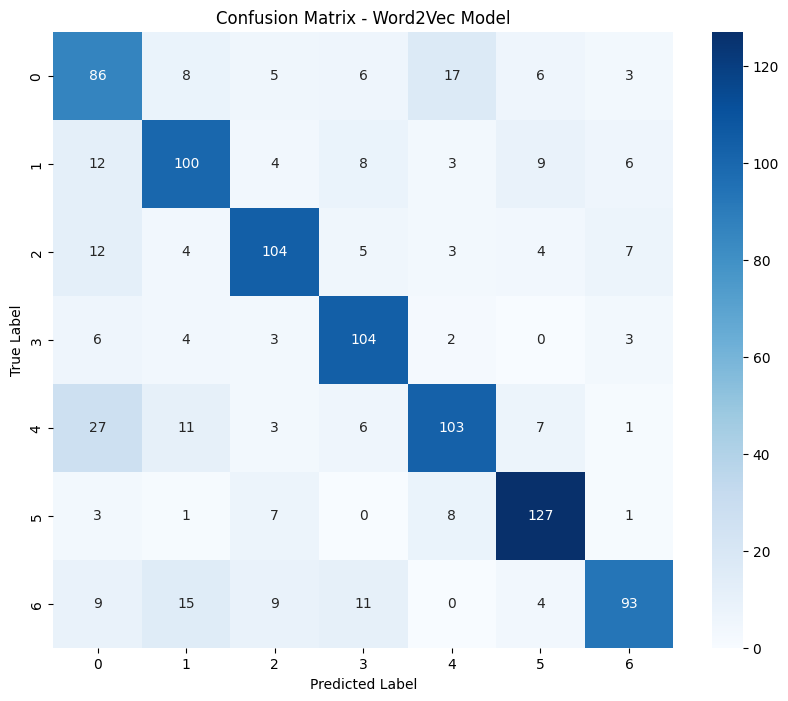

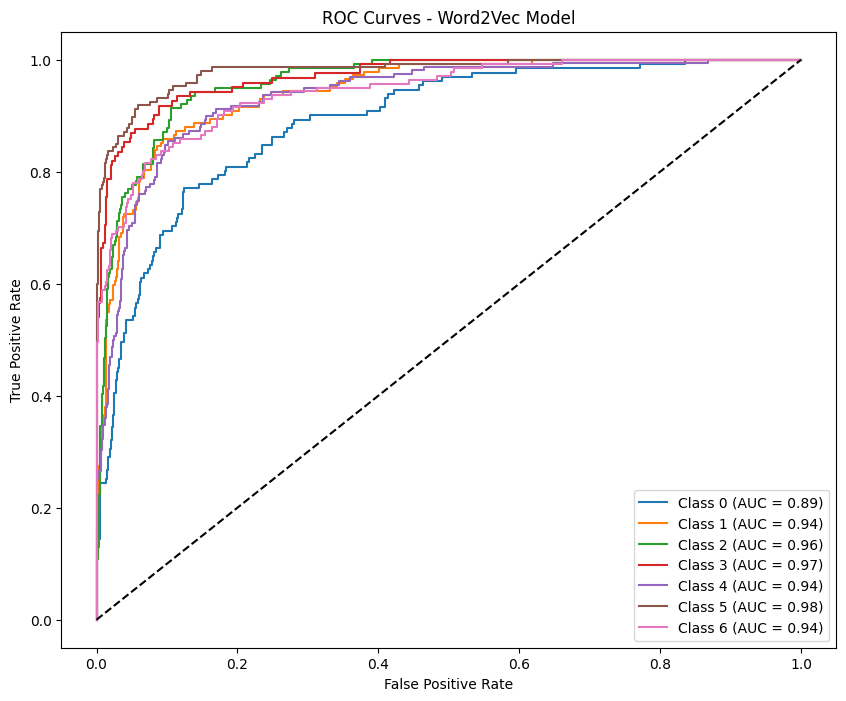

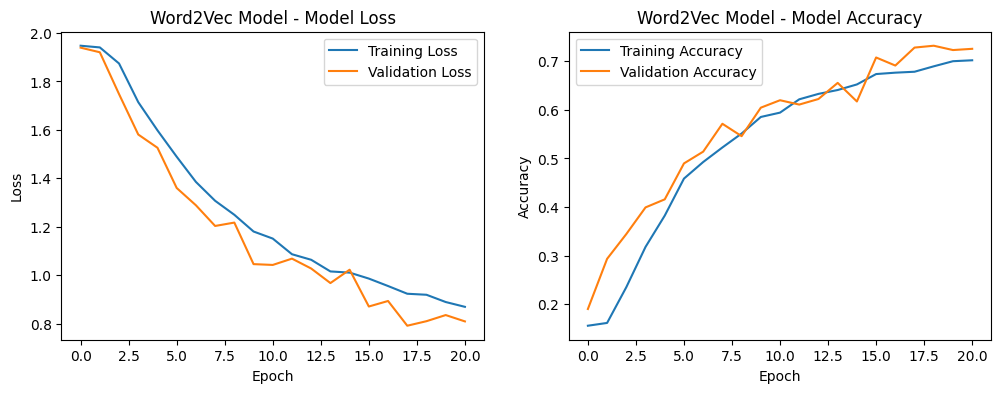

Model Comparison Report

Performance Metrics Comparison:
      Metric  Random Embeddings  Word2Vec
0   Accuracy             0.8388    0.7316
1  Precision             0.8490    0.7381
2     Recall             0.8388    0.7316
3   F1-Score             0.8405    0.7318
4   Mean AUC             0.9761    0.9465

Best Accuracy: Random Embeddings (0.8388)
Best Precision: Random Embeddings (0.8490)
Best Recall: Random Embeddings (0.8388)

Overall Best Model: Random Embeddings
Based on average of accuracy, precision, and recall scores.



In [9]:
# Train and evaluate model with random embeddings
print("Training model with random embeddings...")
model_random = create_ensemble_model_random(max_words, max_len)
history_random, random_results = train_and_evaluate_model(
    model_random, 
    X_random_train, 
    X_random_test, 
    y_train, 
    y_test,
    "Random Embeddings Model"
)

# Train and evaluate model with Word2Vec embeddings
print("\nTraining model with Word2Vec embeddings...")
model_w2v = create_ensemble_model_w2v((X_w2v_train_reshaped.shape[1], 1))
history_w2v, w2v_results = train_and_evaluate_model(
    model_w2v, 
    X_w2v_train_reshaped, 
    X_w2v_test_reshaped, 
    y_train_w2v, 
    y_test_w2v,
    "Word2Vec Model"
)

# After training both models, generate and save the report:
report = generate_comparison_report(random_results, w2v_results)

# Save report to file
with open('model_comparison_report.txt', 'w') as f:
    f.write(report)

# Print report
print(report)